In [1]:
%matplotlib inline
from collections import Counter, OrderedDict, defaultdict
import copy
import glob
import itertools
from itertools import izip
import itertools
import os
import subprocess
import tempfile

from IPython.core.display import HTML, Image
import itertools
import pandas as pd
from matplotlib import gridspec
from matplotlib import pyplot
import matplotlib.patches as mpatches

import matplotlib as mpl
from matplotlib_venn import venn2, venn3
import numpy as np
import scipy
import seaborn as sns

from clipper.src import CLIP_analysis
from clipper.src import get_genomic_regions
import flotilla
from gscripts import GO
from gscripts.general import dataviz
from gscripts.general import parsers
from gscripts.general import region_helpers
from gscripts.rnaseq.helpers import counts_to_rpkm

img_dir = "/home/gpratt/Dropbox/Presentations/random_figures/"

:0: FutureWarning: IPython widgets are experimental and may change in the future.


In [2]:
legend = None

OUTSIDE_LEGEND_SAVEFIG_KWS = dict(bbox_extra_artists=(legend,),
                                  bbox_inches='tight')
from matplotlib import rc

mpl.rcParams['svg.fonttype'] = 'none'

rc('text', usetex=False)
rc('font',**{'family':'sans-serif','sans-serif':['Helvetica']})

In [18]:
count_file = "/projects/ps-yeolab2/encode/analysis/encode_v12/lf_counts.txt"
count_df = pd.read_table(count_file, skiprows=1, index_col=0)
count_df.columns = [os.path.basename(item).split(".")[0] for item in count_df.columns]

rpkm_df = counts_to_rpkm(count_df).T
rpkm_df.columns = [item.split(".")[0] for item in rpkm_df.columns]
flotilla_rpkm_df = rpkm_df.copy()

av_resequencing_count_df = pd.read_table("/home/gpratt/projects/cryptic_exons/analysis/av_resequencing_v2/all_counts.txt", skiprows=1, index_col=0)
av_resequencing_count_df.columns = [os.path.basename(item).split(".")[0] for item in av_resequencing_count_df.columns]

av_resequencing_rpkm_df = counts_to_rpkm(av_resequencing_count_df).T
av_resequencing_rpkm_df.columns = [item.split(".")[0] for item in av_resequencing_rpkm_df.columns]

In [10]:
gene_id_to_name = region_helpers.gene_id_to_name("/projects/ps-yeolab/genomes/hg19/gencode/v19/gencode.v19.annotation.gtf.db")
gene_id_to_type = region_helpers.gene_id_to_type("/projects/ps-yeolab/genomes/hg19/gencode/v19/gencode.v19.annotation.gtf.db")
ensembl_id_to_name = {key.split(".")[0]: value for key, value in gene_id_to_name.items()}

name_to_gene_id = {value: key for key, value in gene_id_to_name.items()}

In [11]:
metadata = pd.DataFrame(index=flotilla_rpkm_df.index)
metadata['sample_id'] = metadata.index
metadata['phenotype'] = metadata.index

In [12]:
mn_study_stress = flotilla.Study(# The metadata describing phenotype and pooled samples
                       metadata,
                       # A version for this data
                       version='0.1.0',
                       expression_data = flotilla_rpkm_df,
                       # Dataframe of the splicing data
                       expression_thresh = 1,
                       species="hg19"
)

2016-03-16 13:46:19	Initializing Study
2016-03-16 13:46:19	Initializing Predictor configuration manager for Study
2016-03-16 13:46:19	Predictor ExtraTreesClassifier is of type <class 'sklearn.ensemble.forest.ExtraTreesClassifier'>
2016-03-16 13:46:19	Added ExtraTreesClassifier to default predictors
2016-03-16 13:46:19	Predictor ExtraTreesRegressor is of type <class 'sklearn.ensemble.forest.ExtraTreesRegressor'>
2016-03-16 13:46:19	Added ExtraTreesRegressor to default predictors
2016-03-16 13:46:19	Predictor GradientBoostingClassifier is of type <class 'sklearn.ensemble.gradient_boosting.GradientBoostingClassifier'>
2016-03-16 13:46:19	Added GradientBoostingClassifier to default predictors
2016-03-16 13:46:19	Predictor GradientBoostingRegressor is of type <class 'sklearn.ensemble.gradient_boosting.GradientBoostingRegressor'>
2016-03-16 13:46:19	Added GradientBoostingRegressor to default predictors
2016-03-16 13:46:19	Loading metadata
2016-03-16 13:46:19	Loading species metadata from ~/f

No phenotype to color mapping was provided, falling back on reasonable defaults.
No phenotype to marker (matplotlib plotting symbol) was provided, so each phenotype will be plotted as a circle in visualizations.
Error loading species hg19 data: HTTP Error 404: Not Found

2016-03-16 13:46:26	Loading expression data
2016-03-16 13:46:26	Initializing expression
2016-03-16 13:46:26	Done initializing expression
2016-03-16 13:46:27	Successfully initialized a Study object!


/home/gpratt/anaconda/lib/python2.7/site-packages/flotilla/data_model/metadata.py:188: UserWarning: MetaData.phenotype_series will be deprecated in 0.3.0
  warnings.warn('MetaData.phenotype_series will be deprecated in 0.3.0')
/home/gpratt/anaconda/lib/python2.7/site-packages/flotilla/visualize/decomposition.py:177: FutureWarning: sort is deprecated, use sort_values(inplace=True) for for INPLACE sorting
  self.magnitudes.sort(ascending=False)
/home/gpratt/anaconda/lib/python2.7/site-packages/flotilla/visualize/decomposition.py:184: FutureWarning: sort is deprecated, use sort_values(inplace=True) for for INPLACE sorting
  x.sort(ascending=True)
/home/gpratt/anaconda/lib/python2.7/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


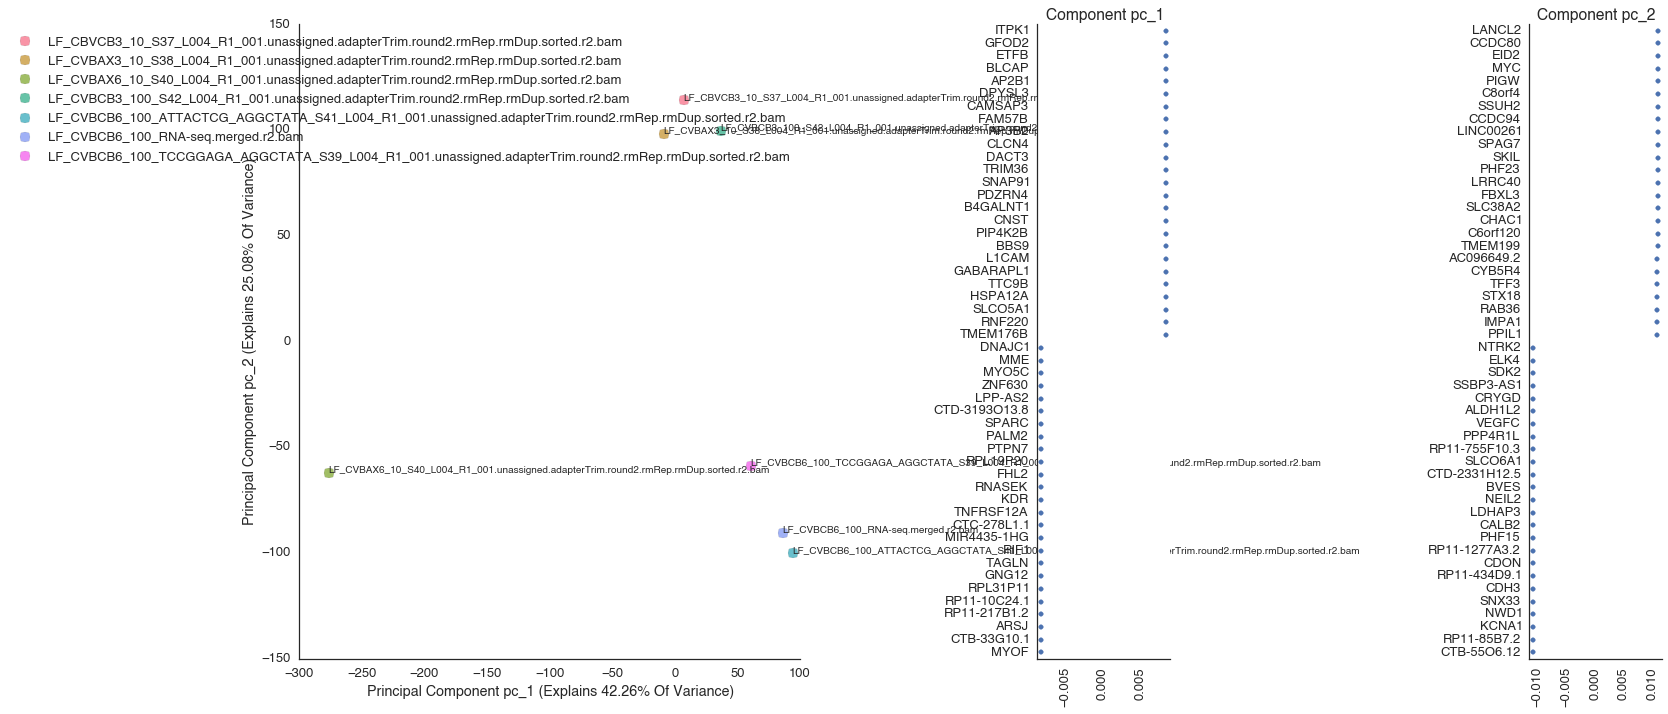

In [13]:
mn_study_stress.plot_pca(feature_subset="all", show_vectors=False, show_point_labels=True)
pyplot.savefig(os.path.join(img_dir, "expression_pca.pdf"))
pyplot.savefig(os.path.join(img_dir, "expression_pca.svg"))

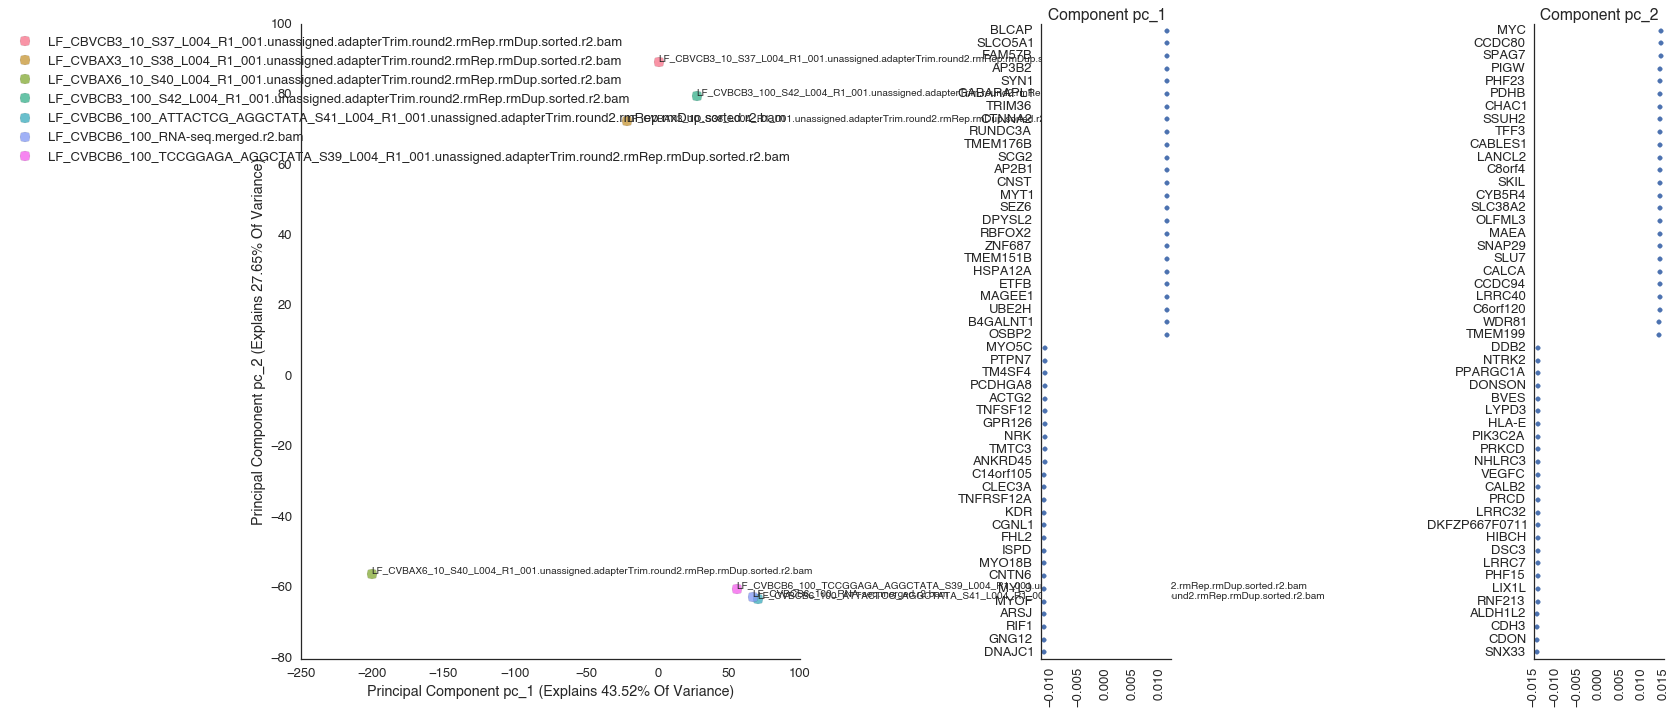

In [14]:
pca = mn_study_stress.plot_pca(feature_subset="gene_type: protein_coding", 
                             show_vectors=False, 
                             show_point_labels=True,
                             most_variant_features=False)
pyplot.savefig(os.path.join(img_dir, "pca.pdf"))
pyplot.savefig(os.path.join(img_dir, "pca.svg"))

In [19]:
fraction_enriched = rpkm_df.div(rpkm_df.sum(axis=1), axis=0)
av_resequencing_fraction_enriched = av_resequencing_rpkm_df.div(av_resequencing_rpkm_df.sum(axis=1), axis=0)

In [20]:
fraction_enriched_merged = pd.merge(fraction_enriched.T, av_resequencing_fraction_enriched.T, left_index=True, right_index=True).T

In [21]:
result = {}
for item in fraction_enriched_merged.index:
    result[item] = list(fraction_enriched_merged.ix[item].sort_values(ascending=False)[:20].iteritems())
    
result = pd.DataFrame(result)
result.applymap(lambda x: (ensembl_id_to_name[x[0]], x[1])).T

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
AV_47d_1_S50_L008_R1_001,"(MT-CO1, 0.0316433297793)","(MT-CO2, 0.0196168825561)","(MT-CO3, 0.0196016665386)","(MT-ATP6, 0.0169370655736)","(MT-RNR2, 0.0157691389497)","(MT-ND4, 0.0155934755042)","(MT-ND2, 0.0144674350964)","(TMSB10, 0.0120659430809)","(MT-ND4L, 0.00939176319011)","(TUBA1A, 0.0093704626597)","(MT-ATP8, 0.00888603725938)","(MT-CYB, 0.0088609820688)","(MT-ND6, 0.00755735091618)","(MT-ND3, 0.00746564131718)","(MT-ND1, 0.00723241537852)","(MT-ND5, 0.00714634519111)","(MT-TC, 0.00635473402677)","(STMN2, 0.00541275903411)","(NEFL, 0.00431879223881)","(ACTG1, 0.00355884630483)"
AV_47d_puro_1_S51_L008_R1_001,"(MT-CO3, 0.014551553942)","(MT-ATP6, 0.0122073114359)","(MT-CO1, 0.0117145114927)","(MT-CO2, 0.0115408929247)","(MT-ND2, 0.0112636243181)","(MT-RNR2, 0.0108333068867)","(MT-ND4, 0.00826659571905)","(MT-ND1, 0.00808370645128)","(MT-CYB, 0.00670130262653)","(MT-ATP8, 0.00621575173585)","(MT-ND3, 0.00573837840385)","(MT-ND4L, 0.00524128264101)","(MT-RNR1, 0.00403472978652)","(JUN, 0.00392182789677)","(MT-ND5, 0.0033334641925)","(EGR1, 0.00315813955364)","(MT-TC, 0.00261455287403)","(EEF2, 0.00247552350428)","(MT-TM, 0.00225805642544)","(MT-ND6, 0.00220908917734)"
AV_ALS17_5_1_S45_L007_R1_001,"(MT-CO1, 0.0262419848454)","(MT-CO3, 0.0175712002473)","(MT-CO2, 0.0175641739856)","(MT-ATP6, 0.0153435069294)","(MT-ND4, 0.0150715002484)","(TMSB10, 0.0132307177401)","(MT-RNR2, 0.0126178776504)","(MT-ND4L, 0.0102817387031)","(MT-ATP8, 0.0096663873338)","(MT-ND2, 0.00828592160778)","(MT-CYB, 0.00822782827748)","(TUBA1A, 0.00768687159635)","(MT-ND6, 0.00756116162453)","(MT-ND1, 0.00748938904187)","(MT-ND5, 0.00737129781619)","(MT-ND3, 0.00647987893001)","(STMN2, 0.00512936970607)","(MT-TC, 0.00502662492873)","(NEFL, 0.00398292118929)","(CD24P4, 0.00365072094722)"
AV_ALS17_5_puro_1_S46_L007_R1_001,"(MT-CO3, 0.0135129340801)","(MT-ND2, 0.00930940375601)","(MT-RNR2, 0.0093090367263)","(MT-ATP6, 0.00918196656659)","(MT-CO1, 0.00911585394174)","(MT-CO2, 0.00881924266305)","(MT-ATP8, 0.00681037981887)","(MT-ND4, 0.00627877057201)","(MT-ND1, 0.00608195567213)","(MT-ND3, 0.00557627514186)","(MT-CYB, 0.00489541889306)","(MT-ND4L, 0.00475682914164)","(MT-RNR1, 0.00325434618606)","(JUN, 0.00319073858461)","(MT-ND5, 0.00288403631028)","(H3F3B, 0.00213702200398)","(MT-ND6, 0.0021169341106)","(MT-TC, 0.00206565856318)","(EGR1, 0.0020550138608)","(EEF2, 0.00205355973031)"
AV_CVB_S56_L008_R1_001,"(MT-CO1, 0.026048017497)","(MT-CO2, 0.0206510486446)","(MT-RNR2, 0.018396566276)","(MT-CO3, 0.0181407276319)","(MT-ND4, 0.0174426047849)","(MT-ATP6, 0.0124813242196)","(TMSB10, 0.0120088148821)","(MT-ND4L, 0.0116817571458)","(MT-CYB, 0.00865560136886)","(MT-ND5, 0.00769717181081)","(MT-ND2, 0.00725565179985)","(MT-ND6, 0.00706125341188)","(TUBA1A, 0.00693969286143)","(MT-ND1, 0.00676405797188)","(MT-ATP8, 0.00609677380173)","(ACTG1, 0.00533653031973)","(NEFL, 0.00488528056169)","(STMN2, 0.00481870212027)","(MT-TC, 0.0047059054285)","(ACTB, 0.00411332447594)"
AV_CVB_puro_S49_L007_R1_001,"(MT-ND2, 0.0141901855455)","(MT-CO3, 0.0128223804228)","(MT-ND1, 0.0116009412562)","(MT-ATP6, 0.0115800581853)","(MT-CO2, 0.0106410746694)","(MT-CO1, 0.00973787960905)","(MT-RNR2, 0.00932865638529)","(MT-ND4, 0.0081974484546)","(MT-CYB, 0.00735034469321)","(MT-ND4L, 0.00646361233869)","(MT-ND3, 0.00591812829161)","(MT-ATP8, 0.00554021067464)","(EGR1, 0.0039801312538)","(JUN, 0.00383856671591)","(EEF2, 0.0031190210534)","(MT-RNR1, 0.00311606429088)","(MT-ND5, 0.00275302344334)","(JUND, 0.00262225274041)","(FOS, 0.00199363872013)","(H3F3B, 0.00185232989844)"
AV_GY6_2_1_S43_L007_R1_001,"(MT-CO1, 0.0252462011174)","(MT-RNR2, 0.0231928916206)","(MT-CO2, 0.0151735302895)","(MT-CO3, 0.0150972991339)","(MT-ND4, 0.0149714002689)","(TMSB10, 0.01108093392)","(MT-ATP6, 0.0097423532167)","(MT-ND4L, 0.00926631613534)","(TUBA1A, 0.00922934743384)","(MT-ND2, 0.00746852883503)","(MT-ND5, 0.00720276268865)","(MT-ND6, 0.00700007783356)","

In [22]:
fraction_enriched.ix['LF-10_S74_L007_R1_001'][fraction_enriched.ix['LF-10_S74_L007_R1_001'] >= 0.446663 ]

ENSG00000207981    0.446683
Name: LF-10_S74_L007_R1_001, dtype: float64

#Look at read complexity

In [110]:
randomer_counts = pd.read_table("/projects/ps-yeolab2/encode/analysis/encode_v12/LF-11_S75_L007_R1_001.unassigned.adapterTrim.round2.rmRep.rmDup.metrics",index_col=0)
randomer_counts.sort_values("total_count", ascending=False).head()

,total_count,removed_count
randomer,,
CCCCCCCCCC,1399,1000
CCCCCCCCAC,769,628
CCCCCCCACC,683,536
GCCCCCCCCC,597,420
CCCCCCCCCG,588,417
CCCCCCCCAG,581,484
CCCCCCCTCC,521,426
CCCCCCCAAC,499,406
CCCCACCCCC,489,397


In [107]:
randomer_counts = pd.read_table("/projects/ps-yeolab2/encode/analysis/encode_v12/223_CLIP_TCCGGAGA-CCTATCCT_L001_R1.C01_223_02_FKBP4.adapterTrim.round2.rmRep.rmDup.metrics",index_col=0)
randomer_counts.sort_values("total_count", ascending=False)

,total_count,removed_count
randomer,,
ACAAG,11597,2504
CCCCC,11074,2822
ACAAA,9071,2093
GCCCC,8520,2085
AAAAC,8155,2007
AAAAG,7975,1926
ACAAT,7945,1796
AAAAT,7583,1807
AAAAA,6106,1399


In [108]:
randomer_counts = pd.read_table("/projects/ps-yeolab2/encode/analysis/encode_v12/569_CLIP_S34_L004_R1_001.F05_569_01_DISC1.adapterTrim.round2.rmRep.rmDup.metrics",index_col=0)
randomer_counts.sort_values("total_count", ascending=False)

,total_count,removed_count
randomer,,
CCCCCCCCCC,2517,1303
CCCCCCCCAC,1350,862
CCCCCCCACC,1227,779
CCCCCCCCCG,1068,604
GCCCCCCCCC,1056,546
TCCCCCCCCC,897,500
CCCCCCCAAC,850,567
CCCCCCACCC,832,558
CCCCCCCCCT,808,461


In [109]:
randomer_counts = pd.read_table("/projects/ps-yeolab2/encode/analysis/encode_v12/568_CLIP_S15_L002_R1_001.F05_568_02_SAM68.adapterTrim.round2.rmRep.rmDup.metrics",index_col=0)
randomer_counts.sort_values("total_count", ascending=False)

,total_count,removed_count
randomer,,
CCCCCCCCCC,3610,1078
CCCCCCCCAC,1948,790
CCCCCCCACC,1852,727
GCCCCCCCCC,1524,483
CCCCCCCCCG,1480,502
TCCCCCCCCC,1197,403
CCCCACCCCC,1156,432
CCCCCCCAAC,1127,475
CCCCCCACCC,1117,442


In [113]:
bar = pd.read_table("/projects/ps-yeolab2/encode/analysis/ad-hoc/lf_suff/bar.metrics", index_col=0)

In [116]:
baz = bar.sum()

In [120]:
baz.removed_count / (baz.total_count * 1.0)

0.74701920128880395

In [126]:
real = pd.read_table("/projects/ps-yeolab2/encode/analysis/encode_v12/LF-10_S74_L007_R1_001.unassigned.adapterTrim.round2.rmRep.rmDup.metrics", index_col=0)

In [129]:
real.sum().removed_count / (real.sum().total_count * 1.0)

0.72119812433831354

#V13 run 

In [23]:
count_file = "/projects/ps-yeolab/encode/analysis/encode_v13/all_counts.txt"
count_df = pd.read_table(count_file, skiprows=1, index_col=0)

rpkm_df = counts_to_rpkm(count_df).T
rpkm_df.columns = [item.split(".")[0] for item in rpkm_df.columns]
flotilla_rpkm_df = rpkm_df.copy()

In [24]:
fraction_enriched = rpkm_df.div(rpkm_df.sum(axis=1), axis=0)
fraction_enriched_merged = pd.merge(fraction_enriched.T, av_resequencing_fraction_enriched.T, left_index=True, right_index=True).T

In [25]:
result = {}
for item in fraction_enriched_merged.index:
    result[item] = list(fraction_enriched_merged.ix[item].sort_values(ascending=False)[:20].iteritems())
    
result = pd.DataFrame(result)
result.applymap(lambda x: (ensembl_id_to_name[x[0]], x[1])).T

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
AV_47d_1_S50_L008_R1_001,"(MT-CO1, 0.0316433297793)","(MT-CO2, 0.0196168825561)","(MT-CO3, 0.0196016665386)","(MT-ATP6, 0.0169370655736)","(MT-RNR2, 0.0157691389497)","(MT-ND4, 0.0155934755042)","(MT-ND2, 0.0144674350964)","(TMSB10, 0.0120659430809)","(MT-ND4L, 0.00939176319011)","(TUBA1A, 0.0093704626597)","(MT-ATP8, 0.00888603725938)","(MT-CYB, 0.0088609820688)","(MT-ND6, 0.00755735091618)","(MT-ND3, 0.00746564131718)","(MT-ND1, 0.00723241537852)","(MT-ND5, 0.00714634519111)","(MT-TC, 0.00635473402677)","(STMN2, 0.00541275903411)","(NEFL, 0.00431879223881)","(ACTG1, 0.00355884630483)"
AV_47d_puro_1_S51_L008_R1_001,"(MT-CO3, 0.014551553942)","(MT-ATP6, 0.0122073114359)","(MT-CO1, 0.0117145114927)","(MT-CO2, 0.0115408929247)","(MT-ND2, 0.0112636243181)","(MT-RNR2, 0.0108333068867)","(MT-ND4, 0.00826659571905)","(MT-ND1, 0.00808370645128)","(MT-CYB, 0.00670130262653)","(MT-ATP8, 0.00621575173585)","(MT-ND3, 0.00573837840385)","(MT-ND4L, 0.00524128264101)","(MT-RNR1, 0.00403472978652)","(JUN, 0.00392182789677)","(MT-ND5, 0.0033334641925)","(EGR1, 0.00315813955364)","(MT-TC, 0.00261455287403)","(EEF2, 0.00247552350428)","(MT-TM, 0.00225805642544)","(MT-ND6, 0.00220908917734)"
AV_ALS17_5_1_S45_L007_R1_001,"(MT-CO1, 0.0262419848454)","(MT-CO3, 0.0175712002473)","(MT-CO2, 0.0175641739856)","(MT-ATP6, 0.0153435069294)","(MT-ND4, 0.0150715002484)","(TMSB10, 0.0132307177401)","(MT-RNR2, 0.0126178776504)","(MT-ND4L, 0.0102817387031)","(MT-ATP8, 0.0096663873338)","(MT-ND2, 0.00828592160778)","(MT-CYB, 0.00822782827748)","(TUBA1A, 0.00768687159635)","(MT-ND6, 0.00756116162453)","(MT-ND1, 0.00748938904187)","(MT-ND5, 0.00737129781619)","(MT-ND3, 0.00647987893001)","(STMN2, 0.00512936970607)","(MT-TC, 0.00502662492873)","(NEFL, 0.00398292118929)","(CD24P4, 0.00365072094722)"
AV_ALS17_5_puro_1_S46_L007_R1_001,"(MT-CO3, 0.0135129340801)","(MT-ND2, 0.00930940375601)","(MT-RNR2, 0.0093090367263)","(MT-ATP6, 0.00918196656659)","(MT-CO1, 0.00911585394174)","(MT-CO2, 0.00881924266305)","(MT-ATP8, 0.00681037981887)","(MT-ND4, 0.00627877057201)","(MT-ND1, 0.00608195567213)","(MT-ND3, 0.00557627514186)","(MT-CYB, 0.00489541889306)","(MT-ND4L, 0.00475682914164)","(MT-RNR1, 0.00325434618606)","(JUN, 0.00319073858461)","(MT-ND5, 0.00288403631028)","(H3F3B, 0.00213702200398)","(MT-ND6, 0.0021169341106)","(MT-TC, 0.00206565856318)","(EGR1, 0.0020550138608)","(EEF2, 0.00205355973031)"
AV_CVB_S56_L008_R1_001,"(MT-CO1, 0.026048017497)","(MT-CO2, 0.0206510486446)","(MT-RNR2, 0.018396566276)","(MT-CO3, 0.0181407276319)","(MT-ND4, 0.0174426047849)","(MT-ATP6, 0.0124813242196)","(TMSB10, 0.0120088148821)","(MT-ND4L, 0.0116817571458)","(MT-CYB, 0.00865560136886)","(MT-ND5, 0.00769717181081)","(MT-ND2, 0.00725565179985)","(MT-ND6, 0.00706125341188)","(TUBA1A, 0.00693969286143)","(MT-ND1, 0.00676405797188)","(MT-ATP8, 0.00609677380173)","(ACTG1, 0.00533653031973)","(NEFL, 0.00488528056169)","(STMN2, 0.00481870212027)","(MT-TC, 0.0047059054285)","(ACTB, 0.00411332447594)"
AV_CVB_puro_S49_L007_R1_001,"(MT-ND2, 0.0141901855455)","(MT-CO3, 0.0128223804228)","(MT-ND1, 0.0116009412562)","(MT-ATP6, 0.0115800581853)","(MT-CO2, 0.0106410746694)","(MT-CO1, 0.00973787960905)","(MT-RNR2, 0.00932865638529)","(MT-ND4, 0.0081974484546)","(MT-CYB, 0.00735034469321)","(MT-ND4L, 0.00646361233869)","(MT-ND3, 0.00591812829161)","(MT-ATP8, 0.00554021067464)","(EGR1, 0.0039801312538)","(JUN, 0.00383856671591)","(EEF2, 0.0031190210534)","(MT-RNR1, 0.00311606429088)","(MT-ND5, 0.00275302344334)","(JUND, 0.00262225274041)","(FOS, 0.00199363872013)","(H3F3B, 0.00185232989844)"
AV_GY6_2_1_S43_L007_R1_001,"(MT-CO1, 0.0252462011174)","(MT-RNR2, 0.0231928916206)","(MT-CO2, 0.0151735302895)","(MT-CO3, 0.0150972991339)","(MT-ND4, 0.0149714002689)","(TMSB10, 0.01108093392)","(MT-ATP6, 0.0097423532167)","(MT-ND4L, 0.00926631613534)","(TUBA1A, 0.00922934743384)","(MT-ND2, 0.00746852883503)","(MT-ND5, 0.00720276268865)","(MT-ND6, 0.00700007783356)","